# CC HITChipDB 

Here I use the phyloseq object instead of dataframes/tibbles as I did in the other documents so that I can use the microbiome package functions and get more used to phyloseq.

I subset the data by the sample ID. The selection of the samples has been performed by Gerben Hermes.

In [28]:
library(vegan)
library(HITChipDB)
library(microbiome)
library(tidyverse)
library(here)
library(DESeq2)
library(vegan)
library(Rtsne)

In [29]:
# load data and helper functions
source(here("R/bayesian_helper.R"))
load(here("data/data_transfer.RData"))
source(here("R/read.R"))

In [30]:
meta_new <- data_transfer[, 1:9]
# create variable subject_id
sample_data(genus)$subject_id <- 
    substring(sample_data(genus)$unique.subjectID, 19, 23)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 10 rows containing non-finite values (stat_bin).”

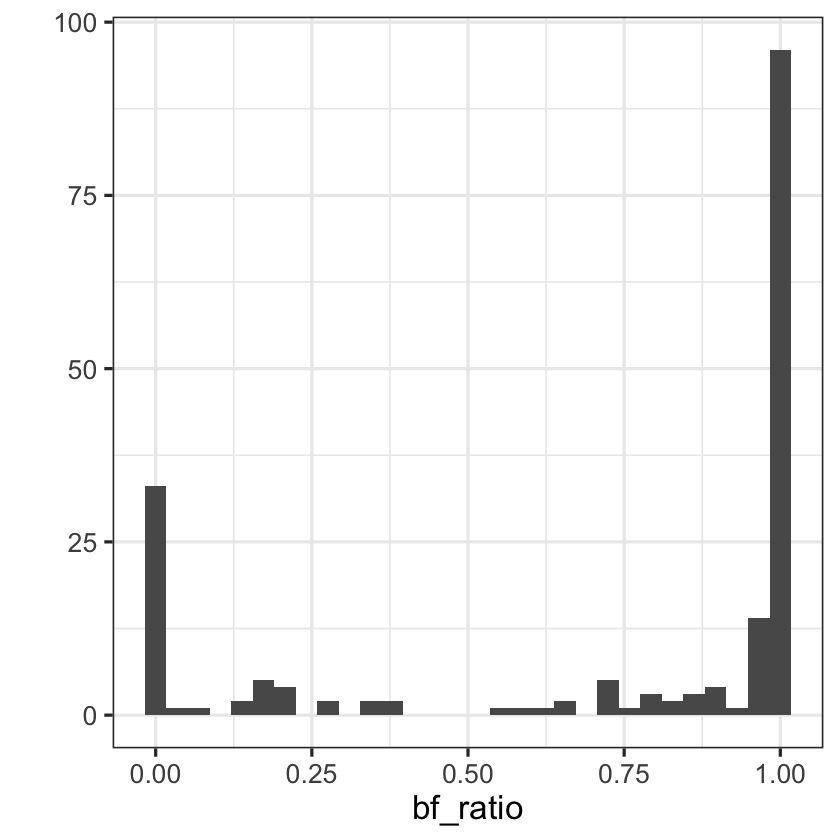

In [31]:
# for ordination, I create bf versus no bf
qplot(data = meta_new, bf_ratio)
# based on the plot maybe it is sensible to make 3 categories

In [32]:
# create grouping variable for ordination
meta_new <- meta_new %>%
  mutate(
      groups = ifelse(
          time == "pre" & cc == "no", "noCCpre", ifelse(
              time == "pre" & cc == "yes", "CCpre", ifelse(
                  time == "post" & cc == "no", "noCCpost", "CCpost"
                  ))),
      bf = ifelse(
          bf_ratio <= 0.25, "lowBF", ifelse(
              bf_ratio <0.75, "mediumBF", "highBF"))
  ) %>% 
  mutate(groups = as.factor(groups), bf = as.factor(bf))

pseq_cc <- subset_samples(genus, sample %in% meta_new$sample)
sample_data(pseq_cc)$time <- meta_new$time
sample_data(pseq_cc)$cc <- meta_new$cc
sample_data(pseq_cc)$age_d_s <- meta_new$age_d_s
sample_data(pseq_cc)$bf_count_s <- meta_new$bf_count_s
sample_data(pseq_cc)$groups <- meta_new$groups
sample_data(pseq_cc)$bf <- meta_new$bf

In [33]:
sample_data(pseq_cc) <- 
    sample_data(pseq_cc)[, c("subject_id", "sample", "time", "cc", "bf_count_s", "age_d_s", "groups", "bf")]

In [34]:
colnames(sample_data(pseq_cc))

[1] "subject_id" "sample"     "time"       "cc"         "bf_count_s"
[6] "age_d_s"    "groups"     "bf"

In [35]:
# diversity indeces
#	inverse_simpson	gini_simpson	shannon	fisher
tab <- global(pseq_cc, index = "all")

Richness
Observed (richness 0)
Diversity
Evenness
Dominance
Rarity


In [36]:
sample_data(pseq_cc)$fisher <- tab$diversities_fisher 
sample_data(pseq_cc)$shannon <- tab$diversities_shannon
sample_data(pseq_cc)$inverse_simpson <- tab$diversities_inverse_simpson
sample_data(pseq_cc)$gini_simpson <- tab$diversities_gini_simpson 

## Ordination 


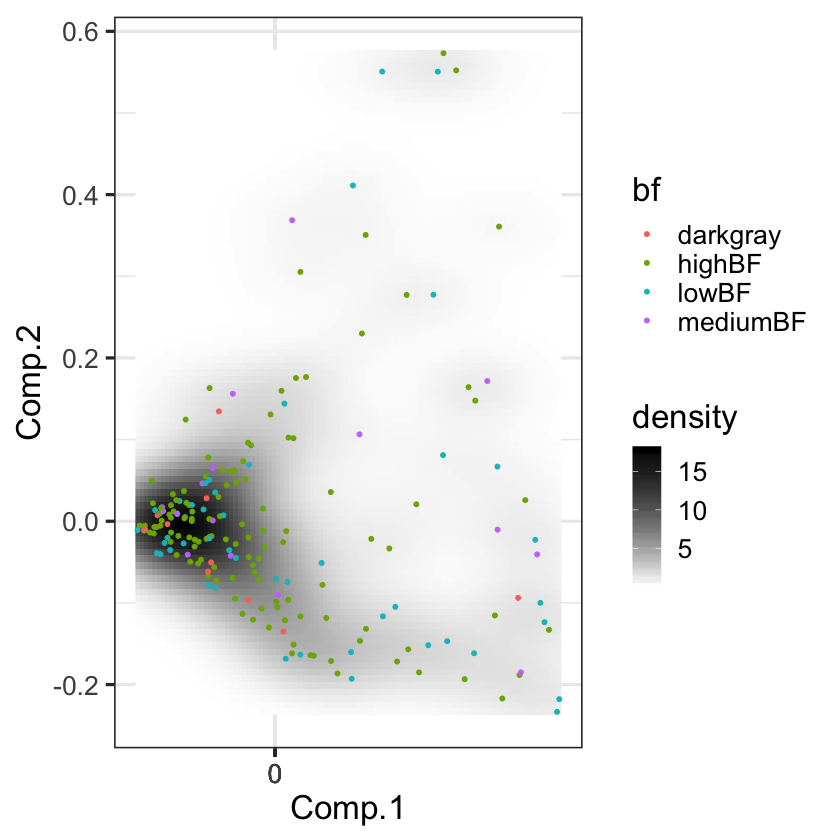

In [37]:
# report this error 
# p <- plot_regression(shannon ~ time, meta(pseq_cc)) + xlab("CC") + ylab("Diversity")

# use relative abundance data
pseq_cc_c <- microbiome::transform(pseq_cc, "compositional") 
# PCoA/NMDS
plot_landscape(pseq_cc_c, "PCoA", "bray", col = "bf") 

# PCoA and MDS

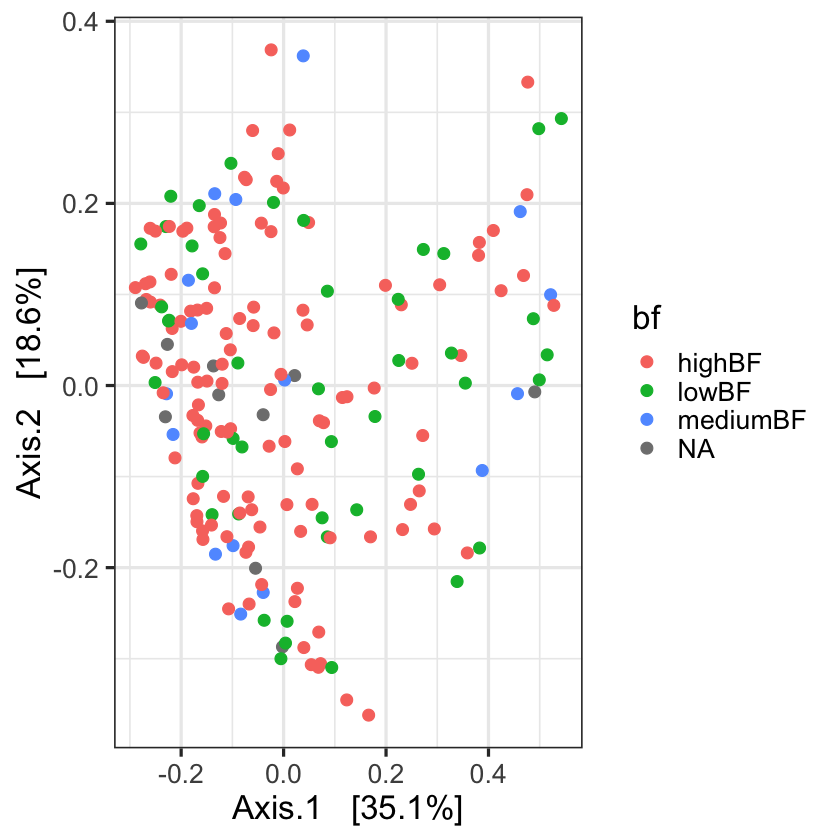

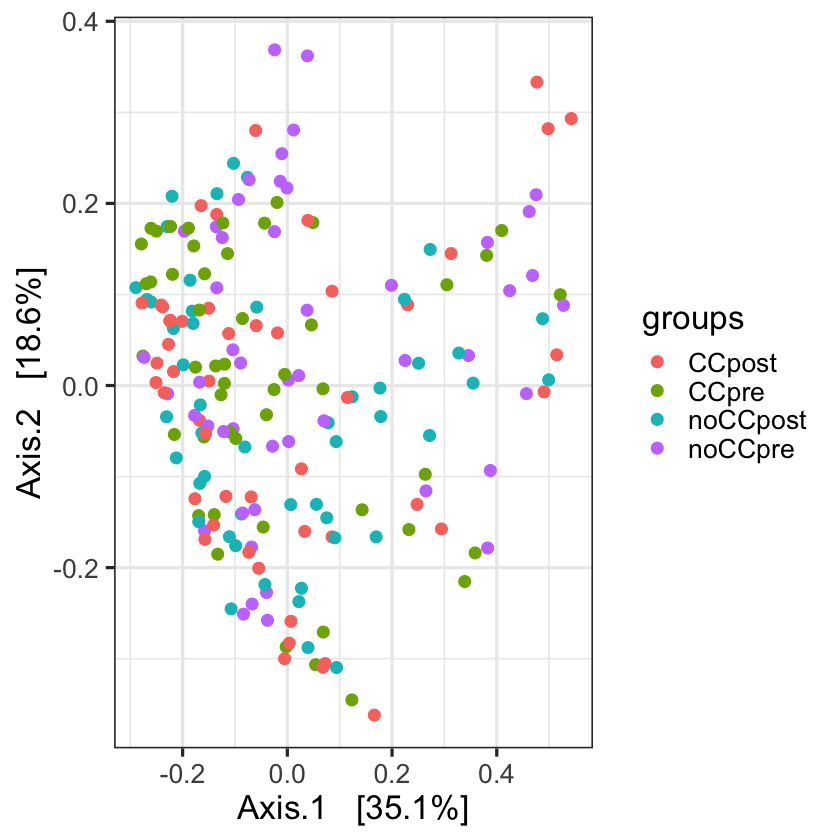

In [38]:
# MDS
cc_mds <- ordinate(pseq_cc, "MDS", "bray")
plot_ordination(pseq_cc, cc_mds, color = "bf") +
    geom_point(size = 3)

# PCoA
cc_pcoa <- ordinate(pseq_cc, "PCoA", "bray")
plot_ordination(pseq_cc, cc_pcoa, color = "groups") +
    geom_point(size = 3)

## Canocial correspondence analysis

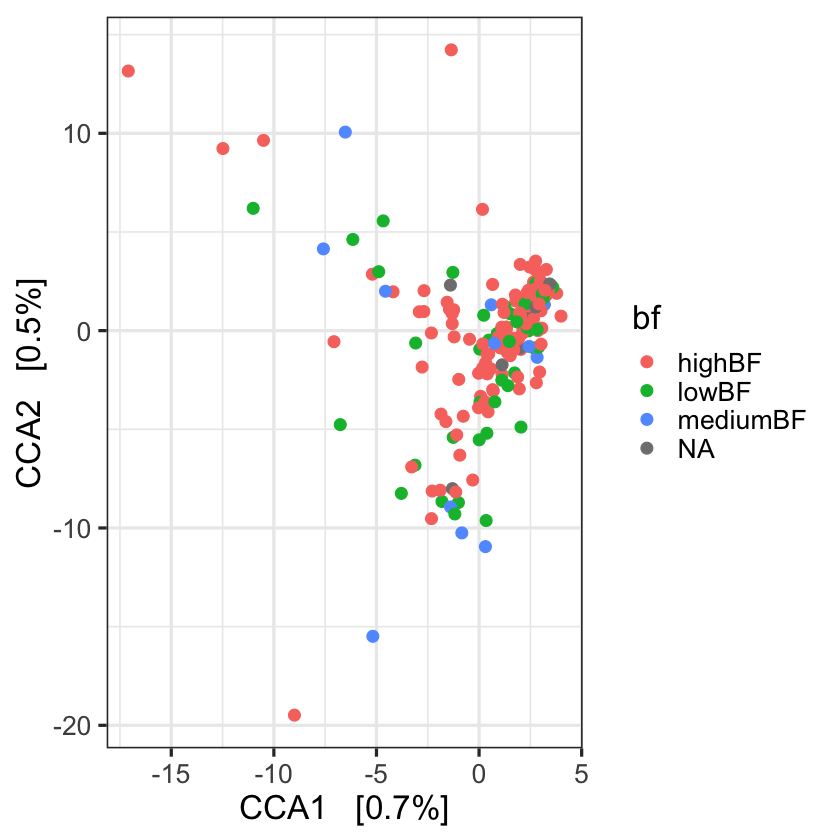

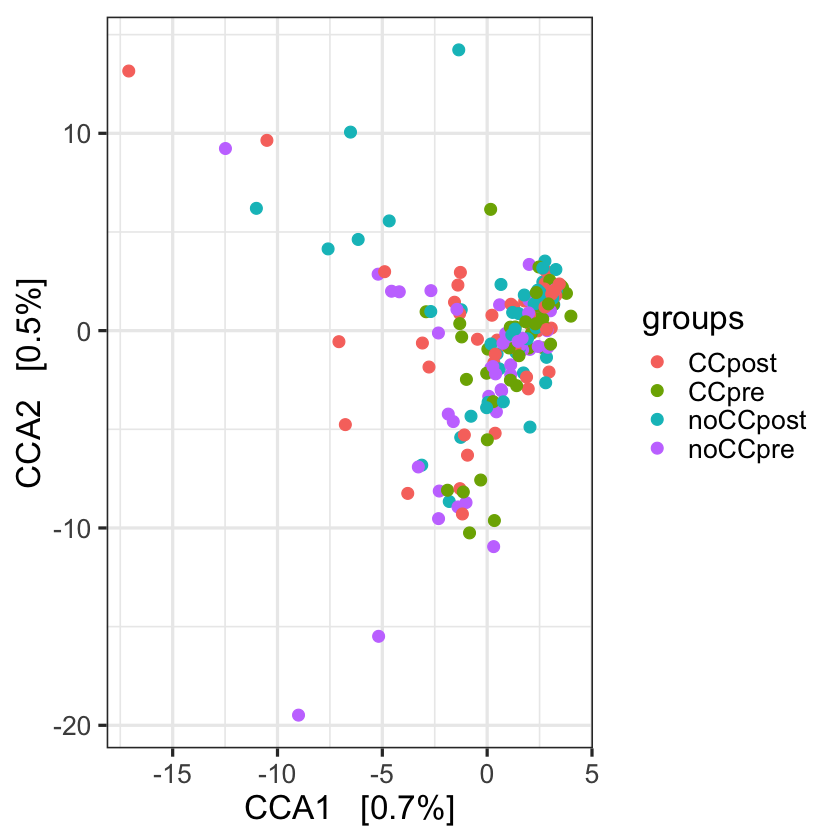

In [39]:
pseq.cca <- ordinate(pseq_cc, "CCA", formula = pseq_cc ~ groups)
plot_ordination(pseq_cc, pseq.cca, type = "samples", color = "bf") +
  geom_point(size = 3)
plot_ordination(pseq_cc, pseq.cca, type = "samples", color = "groups") +
  geom_point(size = 3)

## Partial Least Squares

In [48]:
library(caret)
dataMatrix <- data.frame(groups = sample_data(pseq_cc)$groups, t(otu_table(pseq_cc)))
d_train <- sample(unique(sample_data(pseq_cc)$subject_id), size = 
plsfit <- train(groups ~., data = na.omit(dataMatrix), method = "pls", preProc = "center")

Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”

In [49]:
plsfit

Partial Least Squares 

196 samples
130 predictors
  4 classes: 'CCpost', 'CCpre', 'noCCpost', 'noCCpre' 

Pre-processing: centered (130) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 196, 196, 196, 196, 196, 196, ... 
Resampling results across tuning parameters:

  ncomp  Accuracy   Kappa        
  1      0.2307202  -0.0003925376
  2      0.2490509   0.0193507945
  3      0.2514375   0.0192963266

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was ncomp = 3.

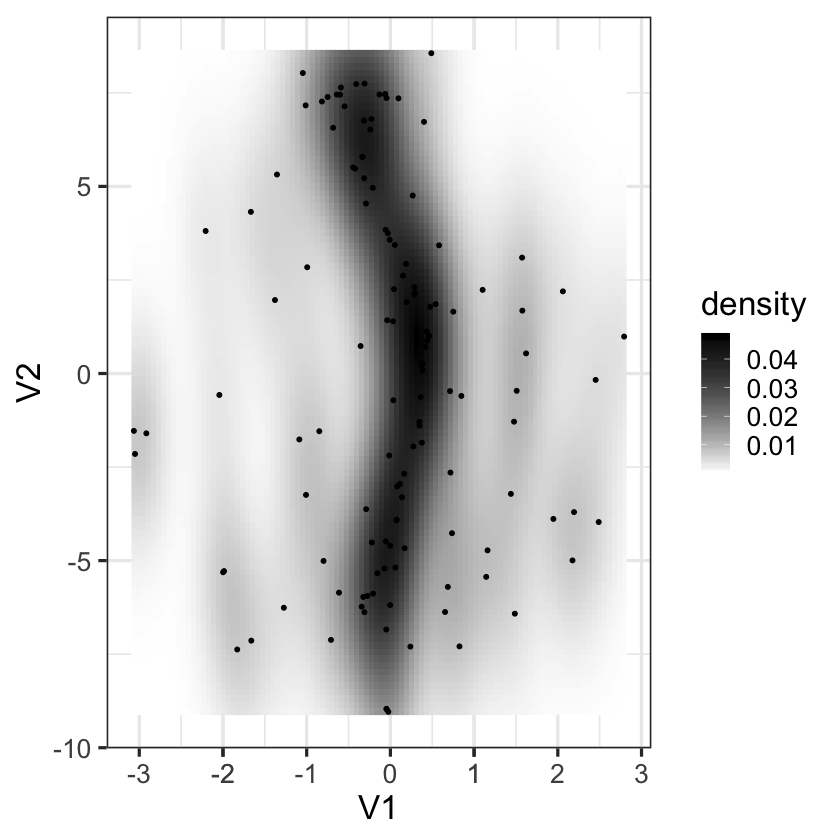

In [42]:
method <- "tsne"
trans <- "hellinger"
distance <- "euclidean"
ps <- microbiome::transform(pseq_cc, trans)
dm <- vegdist(otu_table(ps), distance)
tsne_out <- Rtsne(dm, dims = 2)
proj <- tsne_out$Y
rownames(proj) <- rownames(otu_table(ps))
plot_landscape(proj, legend = T, size = 1)

In [43]:
# how to avoid NA formation here??
# ok it seems that the following is the problem:
# R is restricted to integers that are smaller than 2147483648. 
# therefore I apply disvision by 1000, then it works
pseq_cc2 <- pseq_cc
otu_table(pseq_cc2) <- otu_table(pseq_cc2)/1000
ds2 <- phyloseq_to_deseq2(pseq_cc2, ~ time)

converting counts to integer mode


In [44]:
ds2

class: DESeqDataSet 
dim: 130 196 
metadata(1): version
assays(1): counts
rownames(130): Actinomycetaceae Atopobium ... Uncultured Mollicutes
  Akkermansia
rowData names(0):
colnames(196): sa_11183 sa_5986 ... sa_3548 sa_6223
colData names(12): subject_id sample ... inverse_simpson gini_simpson